In [ ]:
%load_ext autoreload
%autoreload 2

import os

import matplotlib as mpl
import pandas as pd
from matplotlib import animation

from sync.elastic import ELASTIC
from tools.animator import Animator
from tools.sportec_data import SportecData

pd.set_option('display.width', 250)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 30)

%matplotlib inline
mpl.rcParams['animation.embed_limit'] = 100

### Data Preparation

This tutorial demonstrates how to apply ELASTIC to the [Sportec Open DFL Dataset (Bassek et al., 2025)](https://www.nature.com/articles/s41597-025-04505-y). It consists of event and tracking data from seven matches of German Bundesliga's first and second divisions, and can be downloaded from [this link](https://springernature.figshare.com/articles/dataset/An_integrated_dataset_of_spatiotemporal_and_event_data_in_elite_soccer/28196177).
| match_id | home                  | away                   |
|:--------:|-----------------------|------------------------|
| J03WMX   | 1. FC Köln            | FC Bayern München      |
| J03WN1   | VfL Bochum 1848       | Bayer 04 Leverkusen    |
| J03WPY   | Fortuna Düsseldorf    | 1. FC Nürnberg         |
| J03WOH   | Fortuna Düsseldorf    | SSV Jahn Regensburg    |
| J03WQQ   | Fortuna Düsseldorf    | FC St. Pauli           |
| J03WOY   | Fortuna Düsseldorf    | F.C. Hansa Rostock     |
| J03WR9   | Fortuna Düsseldorf    | 1. FC Kaiserslautern   |

After downloading the data, place the XML files by type in the following directories:
- Match information: `data/sportec/metadata`
- Event data: `data/sportec/event`
- Tracking data: `data/sportec/tracking`

Then, choose the match ID you want to synchronize and run the following code.

In [2]:
# It can take about one or two minutes to parse tracking data using kloppy
match_id = "J03WPY"
match = SportecData(match_id)
match.lineup.head()

Loading the tracking data...
Transforming the tracking data coordinates...


,team_id,team_name,home_away,player_id,uniform_number,object_id,player_name,starting,playing_position,captain
0,DFL-CLU-000005,1. FC Nürnberg,away,DFL-OBJ-002G5E,1,away_1,C. Klaus,False,None,False
1,DFL-CLU-000005,1. FC Nürnberg,away,DFL-OBJ-J01K2L,3,away_3,S. Fofana,False,CDM,False
2,DFL-CLU-000005,1. FC Nürnberg,away,DFL-OBJ-002G68,4,away_4,James Lawrence,True,LCB,False
3,DFL-CLU-000005,1. FC Nürnberg,away,DFL-OBJ-0000EJ,5,away_5,J. Geis,True,CDM,False
4,DFL-CLU-000005,1. FC Nürnberg,away,DFL-OBJ-0028T3,6,away_6,L. Tempelmann,True,CAM,False


We categorize events based on [SPADL (Decroos et al., 2019)](https://arxiv.org/abs/1802.07127). The following code converts Sportec event data into the SPADL format and prepares it as a proper input for ELASTIC. (For details on the required input formats, see `sync/schema.py`.)

In [4]:
input_events = match.format_events_for_syncer()
input_events

,period_id,utc_timestamp,player_id,spadl_type,start_x,start_y,success
0,1,2022-10-15 11:01:28.310,home_23,pass,52.50,34.00,True
1,1,2022-10-15 11:01:30.007,home_33,pass,29.56,33.10,True
2,1,2022-10-15 11:01:34.775,home_9,pass,73.94,62.78,False
3,1,2022-10-15 11:01:39.863,away_26,pass,96.18,46.24,True
4,1,2022-10-15 11:01:43.407,away_4,pass,93.28,17.75,True
...,...,...,...,...,...,...,...
1142,2,2022-10-15 12:54:24.460,away_4,interception,94.88,25.78,True
1143,2,2022-10-15 12:54:26.406,home_34,pass,76.04,49.14,True
1144,2,2022-10-15 12:54:32.477,home_8,pass,84.26,45.03,True
1145,2,2022-10-15 12:54:33.965,home_34,cross,95.08,60.38,False


Similarly, tracking data can also be converted into the ELASTIC input format.

In [5]:
input_tracking = match.format_tracking_for_syncer()
input_tracking

,frame_id,period_id,timestamp,utc_timestamp,player_id,ball,x,y,z,speed,accel_s,accel_v
0,10000,1,0.00,2022-10-15 11:01:28.310,home_25,False,51.93,10.77,NaN,0.170228,-0.996197,4.073467
1,10001,1,0.04,2022-10-15 11:01:28.350,home_25,False,51.93,10.77,NaN,0.170228,-0.996197,4.073467
2,10002,1,0.08,2022-10-15 11:01:28.390,home_25,False,51.93,10.77,NaN,0.050478,0.467496,3.505104
3,10003,1,0.12,2022-10-15 11:01:28.430,home_25,False,51.93,10.77,NaN,0.148546,1.516371,2.947025
4,10004,1,0.16,2022-10-15 11:01:28.470,home_25,False,51.93,10.77,NaN,0.261582,2.150426,2.404415
...,...,...,...,...,...,...,...,...,...,...,...,...
1873575,176790,2,3071.60,2022-10-15 12:54:40.610,None,True,73.73,37.78,1.89,4.245815,-6.372231,6.378238
1873576,176791,2,3071.64,2022-10-15 12:54:40.650,None,True,73.72,37.63,1.77,3.917532,-10.840899,10.841558
1873577,176792,2,3071.68,2022-10-15 12:54:40.690,None,True,73.71,37.47,1.62,3.488015,-13.492307,13.493826
1873578,176793,2,3071.72,2022-10-15 12:54:40.730,None,True,73.70,37.30,1.45,2.943445,-14.806163,14.809834


### Data Sychronization

By running the following code, you can synchronize the event and tracking data with these four stages:
1. Kick-off synchronization
2. Major event synchronization (for pass-like, incoming, and set-piece events)
3. Receive detection (for pass-like and set-piece events)
4. Minor event synchronization (for `tackle`, `foul`, `bad_touch`, `take_on`, and `dispossessed`)

<p align="center">
  <img src="docs/sync_stages.png" width="500" />
</p>

In [10]:
syncer = ELASTIC(input_events, input_tracking)
syncer.run()

The tracking data begins after kickoff!


Syncing major events in period 1: 100%|██████████| 587/587 [00:17<00:00, 33.32it/s]


The tracking data begins after kickoff!


Post-syncing minor events: 100%|██████████| 108/108 [00:02<00:00, 46.74it/s]


As a result, the synchronized timstamps are stored in `frame_id` and `synced_ts` columns. The detected end timestamps of pass-like and set-piece events are stroed in `receive_frame_id` and `receive_ts` columns.

In [11]:
syncer.events

,period_id,utc_timestamp,player_id,spadl_type,start_x,start_y,success,next_player_id,next_type,frame_id,receiver_id,receive_frame_id,synced_ts,receive_ts
0,1,2022-10-15 11:01:30.013,home_23,pass,52.50,34.00,True,home_33,pass,10000.0,home_33,10043.0,00:00.00,00:01.72
1,1,2022-10-15 11:01:31.710,home_33,pass,29.56,33.10,True,home_9,pass,10085.0,home_9,10157.0,00:03.40,00:06.28
2,1,2022-10-15 11:01:36.478,home_9,pass,73.94,62.78,False,away_26,pass,10157.0,away_26,10251.0,00:06.28,00:10.04
3,1,2022-10-15 11:01:41.566,away_26,pass,96.18,46.24,True,away_4,pass,10298.0,away_4,10347.0,00:11.92,00:13.88
4,1,2022-10-15 11:01:45.110,away_4,pass,93.28,17.75,True,away_15,pass,10375.0,away_15,10410.0,00:15.00,00:16.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1142,2,2022-10-15 12:54:24.777,away_4,interception,94.88,25.78,True,home_34,pass,176394.0,None,NaN,50:55.76,NaN
1143,2,2022-10-15 12:54:26.723,home_34,pass,76.04,49.14,True,home_8,pass,176457.0,home_8,176481.0,50:58.28,50:59.24
1144,2,2022-10-15 12:54:32.794,home_8,pass,84.26,45.03,True,home_34,cross,176600.0,home_34,176638.0,51:04.00,51:05.52
1145,2,2022-10-15 12:54:34.282,home_34,cross,95.08,60.38,False,away_16,interception,176638.0,away_16,176670.0,51:05.52,51:06.80


### Animating Events and Trajectories 

To check the result of synchronization, you can generate an animation of player and ball trajectories with raw/synchronized events by running the following code. Feel free to choose which segment to visualize by modifying `start_frame` and `end_frame`!

In [13]:
# By default, this code generates and animation for the given match's first minute
start_frame = 10000
end_frame = 11500

merged_data = SportecData.merge_synced_events_and_tracking(syncer.events, match.tracking, match.fps, ffill=True)
segment_data = merged_data.set_index("frame_id").loc[start_frame:end_frame].copy()
animator = Animator({"main": segment_data}, show_events=True)
anim = animator.run()

writer = animation.FFMpegWriter(fps=match.fps)
os.makedirs("animations", exist_ok=True)
anim_path = f"animations/sportec_{match_id}_{start_frame}-{end_frame}.mp4"
anim.save(anim_path, writer=writer)

### Visualizing Individual Windows

To check how ELASTIC decided the best timestamp for each event, you can plot features for the given event.

Event 1: pass by away_2
Matched frame: 10040
Matched time: P1-00:01.60


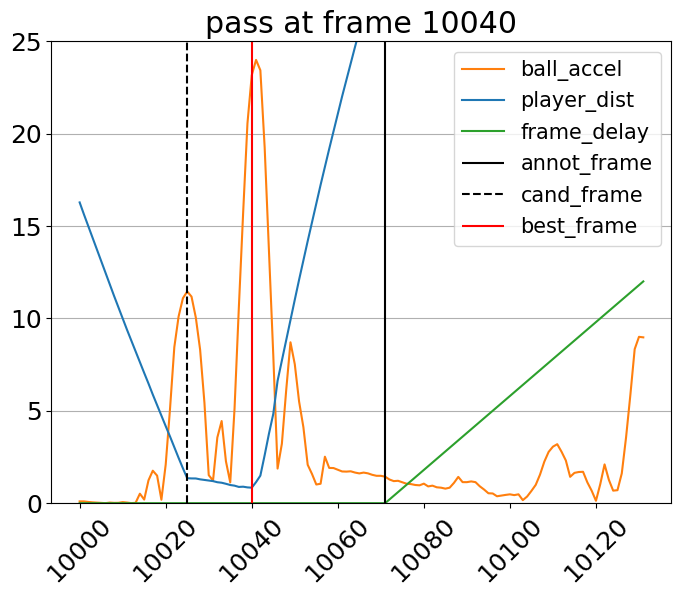

,frame_delay,player_speed,player_accel,ball_accel,ball_height,player_dist,kick_dist,score
frame_id,,,,,,,,
10025,0,1.387579,4.925234,57.283149,0.11,1.28969,1.350926,71.007212
10040,0,1.852186,5.889424,119.935553,0.04,0.83863,59.492619,93.011418


In [45]:
# pass-like event
syncer.plot_window_features(1)

Event 27: interception by home_6
Matched frame: 12314
Matched time: P1-01:32.56


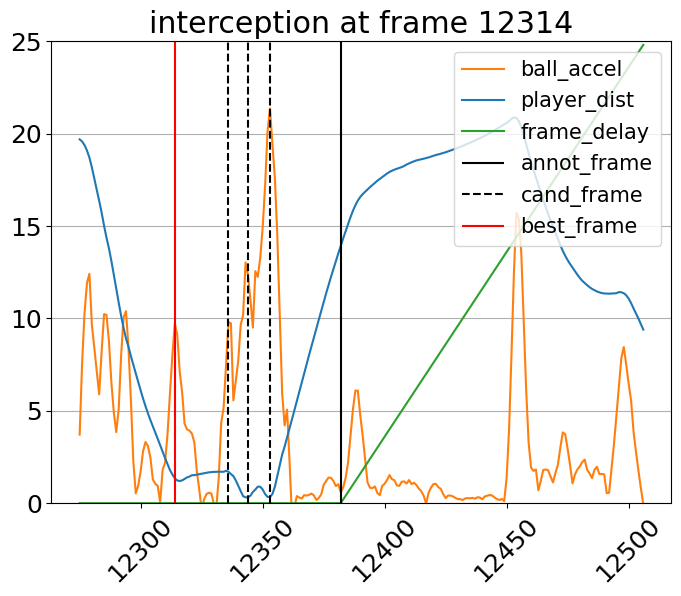

,frame_delay,player_speed,player_accel,ball_accel,ball_height,player_dist,rel_speed,rel_accel,kick_dist,score
frame_id,,,,,,,,,,
12314,0,6.550324,4.035856,48.626768,0.01,1.199067,1.902643,48.626768,19.687417,90.007778
12336,0,6.121765,2.398101,48.970335,0.30,1.232023,1.236176,48.970335,1.749103,73.478656
12344,0,6.073212,2.296888,65.126062,0.13,0.307151,4.983630,61.694113,1.700514,80.942976
12353,0,5.744641,0.977533,106.793076,0.46,0.331287,14.802793,106.793076,0.892860,76.703578


In [21]:
# incoming event
syncer.plot_window_features(27)

Current event: pass by away_7
Next event: pass by away_2

Detected receiver: away_2
Receiving frame: 10025.0
Receiving time: P1-00:01.00


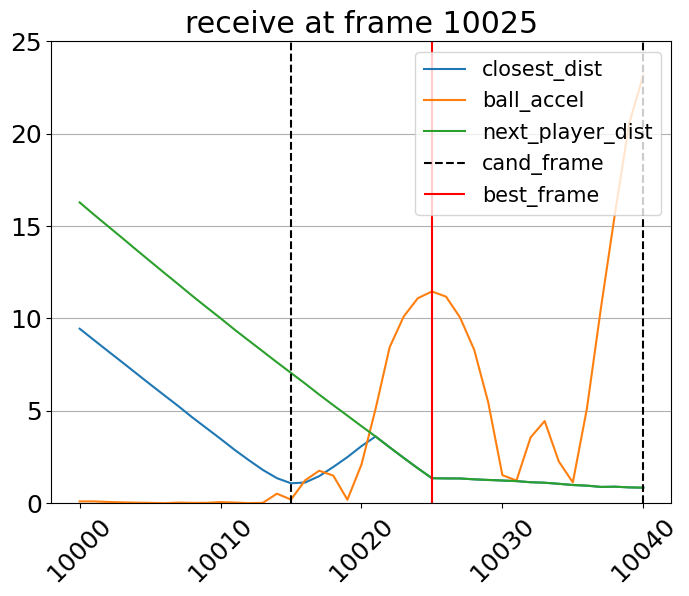

,ball_height,ball_accel,next_player_dist,closest_id,closest_dist,kick_dist,score
frame_id,,,,,,,
10015,0.06,8.787770,5.301868,away_6,1.076708,9.227340,52.012146
10025,0.11,57.283149,1.289690,away_2,1.289690,5.696776,78.505169
10040,0.04,115.802664,0.838630,away_2,0.838630,0.512296,63.584315


In [18]:
# receive
syncer.receive_det.plot_window_features(0)

Event 47: dispossessed by home_28
Matched frame: 13625
Matched time: P1-02:25.00


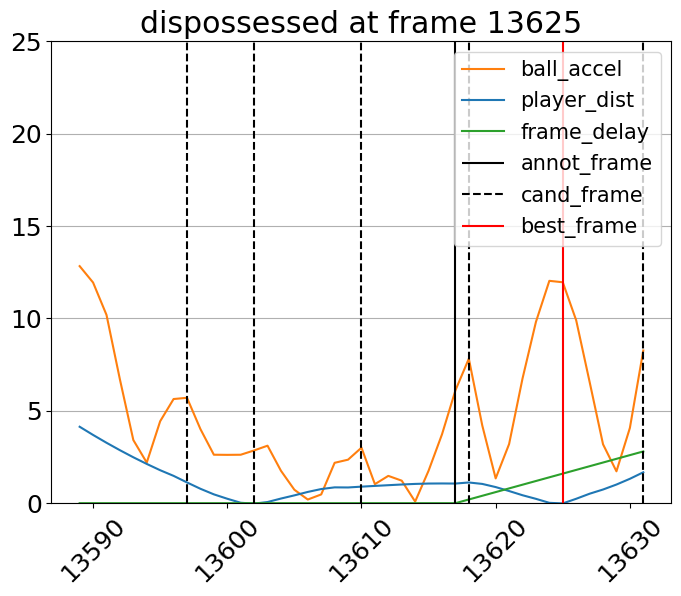

,frame_delay,player_speed,player_accel,ball_accel,ball_height,player_dist,kick_dist,score
frame_id,,,,,,,,
13597,0,1.779470,3.687466,28.507739,0.08,0.240332,1.121708,71.474360
13602,0,1.128985,2.971751,15.554833,0.04,-0.025139,0.894609,65.222114
13610,0,0.355800,3.216303,15.018515,0.00,0.764581,1.120433,57.338399
13618,1,1.161304,4.837438,39.100082,0.07,0.657591,1.120433,66.829661
13625,8,2.271957,3.053318,60.158866,0.06,-0.012944,1.671319,77.808793
13631,14,2.697315,1.377288,41.310519,0.08,0.739422,1.671319,69.592989


In [28]:
# minor event
syncer.plot_window_features(47)